In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

from sklearn.metrics import accuracy_score

ModuleNotFoundError: No module named 'tensorflow_datasets'

In [ ]:
def plot_history(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric])
    plt.title('Model '+metric)
    plt.ylabel(metric)
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

## Load the Dataset and visualize it

In [ ]:
# Download and split the food101 dataset
(train_ds, validation_ds, test_ds), info = tfds.load(
    "food101",
    split=["train", "validation[:50%]", "validation[50%:]"],
    as_supervised=True,
    with_info=True
)

2023-05-15 22:11:26.851860: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [ ]:
#Parameters
IMG_SHAPE = (200, 200, 3)
MAX_VALUE = 255.0
LE_FREEZE = 10**-3
LE_UNFREEZE = 10**-5
B=128
E_FREEZE=5
E_UNFREEZE=1
N_CLASSES = 20

In [ ]:
# Filter the dataset to keep the first 20 classes only.
CLASS_NAMES = info.features['label'].names[:N_CLASSES]
train_ds = train_ds.filter(lambda img, label: label < N_CLASSES)
validation_ds = validation_ds.filter(lambda img, label: label < N_CLASSES)
test_ds = test_ds.filter(lambda img, label: label < N_CLASSES)

In [ ]:
# This step takes too much time. It is not madatory to execute it.
print("Training samples: %d" % train_ds.reduce(0, lambda x,_: x+1).numpy())
print("Validation samples: %d" % validation_ds.reduce(0, lambda x,_: x+1).numpy())
print("Tests samples: %d" % validation_ds.reduce(0, lambda x,_: x+1).numpy())

2023-05-15 22:11:27.132915: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [32]
	 [[{{node Placeholder/_4}}]]
2023-05-15 22:11:27.133156: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [32]
	 [[{{node Placeholder/_4}}]]


Training samples: 15000


2023-05-15 22:11:36.772509: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [8]
	 [[{{node Placeholder/_4}}]]
2023-05-15 22:11:36.772896: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [8]
	 [[{{node Placeholder/_4}}]]


Validation samples: 2514


2023-05-15 22:11:38.404954: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [8]
	 [[{{node Placeholder/_0}}]]
2023-05-15 22:11:38.405216: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [8]
	 [[{{node Placeholder/_4}}]]


Tests samples: 2514


2023-05-15 22:11:39.826214: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [32]
	 [[{{node Placeholder/_4}}]]
2023-05-15 22:11:39.826549: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [32]
	 [[{{node Placeholder/_4}}]]


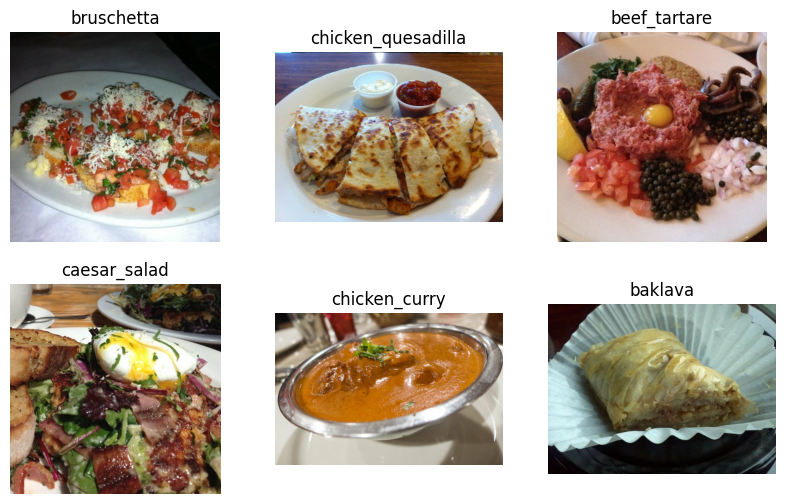

In [ ]:
plt.figure(figsize=(10, 6))
for i, (image, label) in enumerate(train_ds.take(6)):
    ax = plt.subplot(2, 3, i + 1)
    plt.imshow(image)
    plt.title(CLASS_NAMES[label])
    plt.axis("off")

## Resize and normalize

In [ ]:
# TODO Resize the images in the training, validation and test set

def preprocess_image(image, label):
    image = tf.image.resize(image, IMG_SHAPE[:2])
    image = tf.cast(image, tf.float32) / MAX_VALUE
    label = tf.one_hot(label, depth=N_CLASSES)
    return image, label

train_ds = train_ds.map(preprocess_image)
validation_ds = validation_ds.map(preprocess_image)
test_ds = test_ds.map(preprocess_image)

train_ds = train_ds.batch(B)
validation_ds = validation_ds.batch(B)

## Data-Augmentation

No data augmentation is used.

## Training
### Step 1: Only train the head of the network

In [ ]:
%%time

pt_model = keras.applications.MobileNetV2(weights='imagenet',
include_top=False,
input_tensor=None,
pooling=None,
input_shape=IMG_SHAPE)

pt_model.trainable = False

model = tf.keras.Sequential([pt_model,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(100),
    keras.layers.Dropout(0.5),
    keras.layers.Activation('relu'),
    keras.layers.Dense(N_CLASSES, activation='softmax')])

opt = keras.optimizers.Adam(learning_rate=LE_FREEZE)

model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 100)               128100    
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 activation (Activation)     (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 20)                2

2023-05-15 22:11:41.627490: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [32]
	 [[{{node Placeholder/_4}}]]
2023-05-15 22:11:41.628087: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [32]
	 [[{{node Placeholder/_0}}]]


    118/Unknown - 225s 2s/step - loss: 2.3139 - accuracy: 0.2930

2023-05-15 22:15:27.368037: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [8]
	 [[{{node Placeholder/_4}}]]
2023-05-15 22:15:27.368433: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [8]
	 [[{{node Placeholder/_3}}]]


118/118 [==============================] - 264s 2s/step - loss: 2.3139 - accuracy: 0.2930 - val_loss: 1.4616 - val_accuracy: 0.5975


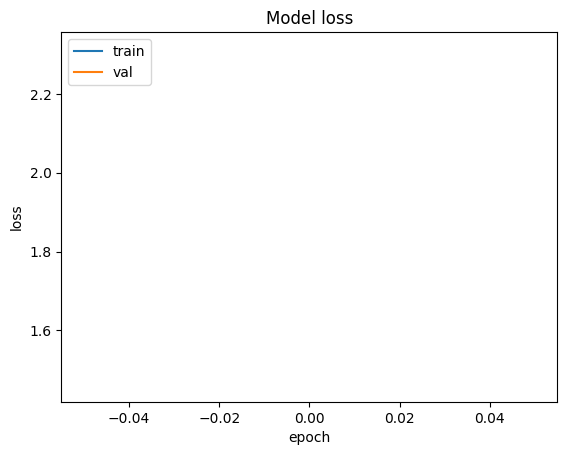

In [ ]:
step1_history = model.fit(train_ds, epochs=E_FREEZE, verbose=1, validation_data=validation_ds) # You should us a relatively big learning rate: 1e-3
plot_history(step1_history, 'loss')

### Step 2: Fine-Tune the whole model

In [ ]:
model.layers[0].trainable = True
opt = keras.optimizers.Adam(learning_rate=LE_UNFREEZE)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
step2_history = model.fit(train_ds, epochs=E_UNFREEZE, verbose=1, validation_data=validation_ds) # You should us a relatively big learning rate: 1e-3
plot_history(step2_history, 'loss')

     84/Unknown - 854s 10s/step - loss: 2.3270 - accuracy: 0.2998

## Test the fine-tuned model

In [ ]:
%%time
# Predict the test set
y_pred = model.predict(test_ds, verbose=1)

# De-encode the onehot encoded labels
y_pred = np.argmax(y_pred, axis=1)
y_true = np.concatenate([np.argmax(y.numpy(), axis=1) for x, y in test_ds], axis=0)

In [ ]:
%%time
# Accuracy
acc = accuracy_score(y_true, y_pred)
print("Accuracy:", acc)

In [ ]:
def show_images_prediction(page=0):
    test_examples = (np.concatenate([x.numpy() for x, y in test_ds])+1)/2*255
    test_examples = test_examples.astype("uint32")
    
    page_size = 20
    nrows = 4
    ncols = 5
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 12))
    fig.set_size_inches(20, 16)

    start_i = page * page_size
    for i, ax in enumerate(axes.flat):
        im = ax.imshow(test_examples[i+start_i])
        ax.set_axis_off()
        ax.set_title("Pred: "+CLASS_NAMES[y_pred[i+start_i]]+"\nTrue: "+CLASS_NAMES[y_true[i+start_i]])
        ax.xaxis.set_ticks([])
        ax.yaxis.set_ticks([])

    plt.show()
show_images_prediction(2)